Age-Sex Standardized Poisson-Based Interrupted Time Series Analysis
======

Introduction
------

This tutorial describes how to perform an age-sex standardized interrupted time series analysis based upon Poisson regression using the R programming language. 

**When would you use Poisson-Based Interrupted Time Series Analysis (PBITSA)?**

1. **You Have Time Series Data of an Intervention/Policy.** An interrupted time series analysis is a quasi-experimental method used to evaluate the impact of a policy or intervention by comparing trends in an outcome before and after the intervention is put in place.

2. **You Want to Model Compare Rates Before/After a Specific Point.** The most common form of interrupted time series analysis is based upon linear regression. This works if your outcome is a continuous variable (or closely approximated by one). For example, you might look at the concentration of a particular air pollutant before and after some policy change. There are plenty of tutorials on this type of interrupted time series analysis available elsewhere, but in short, you create a dummy variable for whether or not the observation occurred after the interruption, and you perform a regression with the outcome on time, the interruption dummy, and an interaction between time and the interruption dummy.

3. **Your Outcome is a Count Variable.** But what if your outcome isn't a simple continuous variable? What if it's a count variable? Say that you know the annual count of how many new lung cancer cases were found (lung cancer incidence) and how many people died from lung cancer (lung cancer mortality), and you want to know if these outcomes were affected by a certain policy. This variable is not continuous (you can't have 5.5 lung cancer mortalities in a year), and the meaning of the count variable depends upon the base population size (6 lung cancer mortalities in a year might not sound like a lot, but it is if there are only 100 people in the population you're studying). This is when you use PBITSA.

**When would you want to age-sex standardize?**

If age and sex affect your outcome and the age and sex distribution of the population is changing over time, then you need to take that into account by age-sex standardization. Let's say that we want to measure the impact of a policy on hard-candy consumption and that, over the period of your study, the population is becoming older. Old people eat more hard candy than young people, so even if the within-age group rates stay the same, the overall prevalence of hard candy consumption would increase -- giving you a spurious result. Age-sex standardization adjusts for changes to the age and sex distribution of the population over time.

Depending upon your research question, there might be other things you need to standardize throughout your study period. Say that you're looking at prostate cancer. Since prostate cancer affects males, you shouldn't adjust for sex -- but you still might want to standardize for age-groups. 

The Current Study
----------

This tutorial is based upon my [MPH Dissertation](https://www.theodorecaputi.com/files/thesis.pdf), which I completed at University College Cork in Cork, Republic of Ireland, in 2017-2018. My dissertation explored the effect of Ireland's 2004 Comprehensive Workplace Smoking Ban on lung cancer incidence and mortality. Count data was available for lung cancer incidence and mortality, and so, to perform an interrupted time series analysis, I had to use PBITSA. 

The Data
----------
[//]: <> (**Note:** I don't currently have permission to share the actual data I used in my study, and so I simulated data in the same format using the fakeR package for R. This is simply a tutorial -- all the results presented below are fake. Read my [thesis](https://www.theodorecaputi.com/files/thesis.pdf) for the real results!) 

1994-2015 count data was available for lung cancer incidence and mortality such that every observation was identified by a combination of year X age-group X sex and lung cancer incidence and mortality were given as raw counts. That is, one observation could be that there were 126 lung cancer incidences and 68 lung cancer mortalities among females aged 50-54 in 2004, and another could be that there were 269 lung cancer incidences and 45 lung cancer mortalities among males aged 85+ in 2009. 

For this analysis to work, you AT LEAST need population estimates in the same categories as those for your count variable (for this study, population data by year X age-group X sex).

Depending on the analysis you want to run, you might want to adjust for some confounders. For this analysis, active smoking and air quality are potential confounders. I had access to micro-data on smoking prevalence (proportion of active smokers) and smoking frequency (average number of cigarettes per day), and so I could aggregate that to either overall smoking prevalence/frequency per year or year X age-group X sex level smoking prevalence/frequency. Air quality data was only sparsely available (readings at different sites on different dates), and so I averaged it all together by year to create overall annual Particulate Matter 2.5 (PM2.5) concentration. In the main analysis (shown here), we include overall smoking prevalence and frequency as confounders in the model.  

First, we have to do a bit of data cleaning.


In [31]:
## Housekeeping
rm(list=ls())


## Install packages
if(!require("pacman")) install.packages("pacman")
pacman::p_load(WordR, MASS, plyr, foreign, data.table,lubridate, rJava, WordR, ReporteRs, fakeR, car,
  flextable, WordR, rJava, ReporteRs, ggplot2, dplyr, devtools, formula.tools, stringr, rlang, lmtest)
install_github("tlcaputi/tlcPack"); library(tlcPack)


## Set working directory where the data is
setwd("C:/Users/tcapu/Google Drive/UCC/manuscript/SmokingBanLungCancer/analyze")


y <- readRDS("./input/data_new.rds") 

y <- y %>%
      rename(
        lungMortality = lungMortalityCases,
        lungIncidence = lungIncidenceCases,
        brainMortality = brainMortalityCases,
        brainIncidence = brainIncidenceCases,
        smoke_rate = total_smoking_rate,
        smoke_frequency = total_smoking_frequency,
        age_sex_smoke_rate = age_sex_smoking_rate,
        age_sex_smoke_frequency = age_sex_smoking_frequency,
        smoke_price = real_price
      )


y <- y %>%
      mutate(lungMortality = ifelse(lungMortality=='..', 0, lungMortality)) %>%
      mutate(
        year = as.numeric(year),
        population = as.numeric(population),
        lungMortality = as.numeric(lungMortality),
        lungIncidence = as.numeric(lungIncidence),
        brainMortality = as.numeric(brainMortality),
        brainIncidence = as.numeric(brainIncidence),
        int2004 = ifelse(year<2004, "preban", "postban"),
        year_from_baseline = year - min(year)
      ) %>% filter(sex!="Both sexes", year <=2015)


y <- y  %>% mutate(
  lungIncidence = ifelse(is.na(lungIncidence), 0, lungIncidence),
  lungMortality = ifelse(is.na(lungMortality), 0, lungMortality),
  brainIncidence = ifelse(is.na(brainIncidence), 0, brainIncidence),
  brainMortality = ifelse(is.na(brainMortality), 0, brainMortality)
)


y <- y %>% group_by(year, sex) %>% mutate(totalPopulation = sum(population)) %>%
            ungroup()

y <- y %>% mutate(
          lungIncidenceRate = lungIncidence/population,
          lungMortalityRate = lungMortality/population,
          brainIncidenceRate = brainIncidence/population,
          brainMortalityRate = brainMortality/population,
          weighting = population/totalPopulation
        ) %>% mutate(
          lungIncidenceSumUp = lungIncidenceRate * weighting,
          lungMortalitySumUp = lungMortalityRate * weighting,
          brainIncidenceSumUp = brainIncidenceRate * weighting,
          brainMortalitySumUp = brainMortalityRate * weighting
        )

y <- y %>% group_by(year) %>% mutate(
  lungIncidence_ASR = sum(lungIncidenceSumUp),
  lungMortality_ASR = sum(lungMortalitySumUp),
  brainIncidence_ASR = sum(brainIncidenceSumUp),
  brainMortality_ASR = sum(brainMortalitySumUp)
) %>% ungroup()


## Now we select only the variables we need for analysis
y <- y %>%
    select(
      sex, # Male or Female
      year, # Year
      year_from_baseline, # Year since 1994
      ageGroup, # 5-year age groups from 40 to 85 and then 85+
      population, # number of Irish people in the sex X age group
      pm2p5, # Yearly particulate matter 2.5 concentration
      pm2p5_lag3, # 3-year lagged particulate matter 2.5 concentration
      smoke_rate, # Annual Irish smoking prevalence
      smoke_frequency, # Annual avg. number of cigs per day
      lungMortality, # Cases of lung mortality within age X sex X year
    ) %>% arrange(ageGroup, sex, year) %>% ungroup()


Skipping install of 'tlcPack' from a github remote, the SHA1 (4d8015e0) has not changed since last install.
  Use `force = TRUE` to force installation


And now we can take a look.

In [32]:
y %>% head()

sex,year,year_from_baseline,ageGroup,population,pm2p5,pm2p5_lag3,smoke_rate,smoke_frequency,lungMortality
Female,1994,0,40-44 years,116.5,30.20692,NA,0.2465582,3.782245,5
Female,1995,1,40-44 years,118.6,29.08168,NA,0.2428202,3.760822,9
Female,1996,2,40-44 years,120.4,27.95643,NA,0.2390823,3.739400,9
Female,1997,3,40-44 years,124.0,26.83119,30.20692,0.2353444,3.717978,5
Female,1998,4,40-44 years,126.3,25.70594,29.08168,0.2316065,3.696555,10
Female,1999,5,40-44 years,128.2,24.58070,27.95643,0.2278686,3.675133,6


The Model
---------

For simplicity, in this tutorial, we'll focus on lung cancer mortality. You could apply the same technique to lung cancer mortality just by changing the left-hand side variable name.

**Basic (Linear) Model**

The basic model is pretty straightforward. You are predicting lung cancer incidence or mortality using a linear term for time, a dummy variable for whether the observation is before/after the interruption, an interaction term between time and the dummy variable, and other variables for confounders. 

$E(Y_{t,s,a})  = \beta_0 + \beta_1*T_{t,s,a} + \beta_2 * \textrm{Post-Ban}_{t} + \beta_3 * \textrm{Post-Ban}_{t} * T_{t,s,a} + \beta_4 * C_{t,s,a} + \epsilon_{t,s,a}$

**The Poisson Model**

Recall that a Poisson model is **not** linear -- it's log-linear. That means that we are essentially predicting the natural logarithm of the outcome, rather than the outcome itself. 

The outcome variable we are investigating is the natural logarithm of the count of either lung cancer incidence or mortality. But, of course, the count itself doesn't tell you much without knowing the whole population -- it's like having the numerator without the denominator. So you have to adjust for the population using an offset term. 

An offset term sets the model coefficient to exactly 1. Essentially, what we are saying here is that, before we model everything else, we need to account for a certain specific number on the right-hand side of the model. Without the offset term, we are predicting the natural logarithm of the count variable. With the offset on the right-hand side (equivalent to a negative offset on the left-hand side), we are predicting $\ln(count) - \ln(population)$. Recall from high school math

$ \ln(A) - \ln(B) = \ln(\frac{A}{B}) $

Therefore, the left-hand side of the model is now equivalent to the natural logarithm of the count over the population, which is the rate.

For the mathematically/statistically inclined, the final PBITSA model is formualted as follows:

$\ln(E(Y_{t,s,a}))  = \beta_0 + \beta_1*T_{t,s,a} + \beta_2 * \textrm{Post-Interruption}_{t,s,a} + \beta_3 * \textrm{Post-Interruption}_{t,s,a} * T_{t,s,a} + \beta_4 * C_{t,s,a} + \epsilon_{t,s,a}$

In [33]:
basefit_formula <- as.formula("lungMortality ~ ageGroup + sex + offset(log(population)) + smoke_rate + smoke_frequency")

basefit <- glm(basefit_formula, data = y, family = poisson)

summary(basefit)


Call:
glm(formula = basefit_formula, family = poisson, data = y)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.3074  -1.1027  -0.0426   0.9688   4.8095  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -3.96358    0.13177 -30.080  < 2e-16 ***
ageGroup45-49 years  0.91204    0.06946  13.131  < 2e-16 ***
ageGroup50-54 years  1.83876    0.06327  29.063  < 2e-16 ***
ageGroup55-59 years  2.51632    0.06112  41.169  < 2e-16 ***
ageGroup60-64 years  3.11410    0.06000  51.900  < 2e-16 ***
ageGroup65-69 years  3.60885    0.05945  60.702  < 2e-16 ***
ageGroup70-74 years  3.97289    0.05924  67.059  < 2e-16 ***
ageGroup75-79 years  4.25016    0.05925  71.730  < 2e-16 ***
ageGroup80-84 years  4.37474    0.05971  73.269  < 2e-16 ***
ageGroup85+ years    4.29703    0.06070  70.792  < 2e-16 ***
sexMale              0.65510    0.01093  59.921  < 2e-16 ***
smoke_rate           2.27386    0.40570   5.605 2.09e-08 ***
smoke_freque

**Autocorrelation**

We should consider if there is significant autocorrelation in the residuals of the model. A common rule of thumb is to look for a Durbin-Watson test statistic between 1.5 and 2.5. If it's in that range, you can proceed without lag terms -- if not, you should consider testing for some significant lag terms. 

Here, we just test for 1, 2, and 3-year lag terms directly through a stepwise regression. We add every significant lag term to the model as a confounder. 

[//]: <> ((We do this even though the Durbin-Watson is not significant because we know autocorrelation exists in the original, non-simulated, data).)

Because we have lag terms, the error term is now modelled as:

$\epsilon_{t,s,a} = \rho * \epsilon_{t-Q, s, a} + u_{t,s,a} $


In [34]:
durbinWatsonTest(basefit, max.lag=3) 

lag_names <- c()
  y$age_sex_group <- paste0(y$ageGroup, y$sex)

  for(k in unique(y$age_sex_group)){
    for (j in 1:3){
      nam <- paste0("lungMortality_lag", j)
      y[y$age_sex_group==k,nam] <- lag(as.numeric(unlist(y[y$age_sex_group==k, "lungMortality"])), j)
      lag_names <- u(lag_names, nam)
    }
  }

mod_w_lag_formula <- as.formula(paste(c(basefit_formula, lag_names), collapse="+"))
mod_w_lag <- lm(mod_w_lag_formula, data = na.omit(y))

step1 <- step(mod_w_lag, na.rm=T)
lags <- grep("lag", names(step1$coefficients), value=T)


if(length(lags)>0){
    formula_w_lags <- as.formula(paste(c(as.character(basefit_formula), lags), collapse="+"))
} else {
    formula_w_lags <- basefit_formula
}

model_w_lags <- glm(formula_w_lags, data = y, family = poisson)

summary(model_w_lags)

 lag Autocorrelation D-W Statistic p-value
   1       0.4639009      1.059313       0
   2       0.4329246      1.113317       0
   3       0.4101562      1.142450       0
 Alternative hypothesis: rho[lag] != 0

Start:  AIC=1873.52
lungMortality ~ ageGroup + sex + offset(log(population)) + smoke_rate + 
    smoke_frequency + lungMortality_lag1 + lungMortality_lag2 + 
    lungMortality_lag3

                     Df Sum of Sq   RSS    AIC
<none>                            48352 1873.5
- sex                 1     367.9 48720 1874.4
- smoke_frequency     1     779.1 49131 1877.6
- smoke_rate          1    1425.4 49777 1882.6
- ageGroup            9    4984.7 53337 1892.8
- lungMortality_lag3  1    3520.0 51872 1898.2
- lungMortality_lag1  1    4415.0 52767 1904.7
- lungMortality_lag2  1    5089.0 53441 1909.5



Call:
glm(formula = formula_w_lags, family = poisson, data = y)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.1888  -0.9825   0.0378   0.9864   3.5148  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -3.9708867  0.1360732 -29.182  < 2e-16 ***
ageGroup45-49 years  0.9432878  0.0753907  12.512  < 2e-16 ***
ageGroup50-54 years  1.8024521  0.0697899  25.827  < 2e-16 ***
ageGroup55-59 years  2.4349953  0.0698428  34.864  < 2e-16 ***
ageGroup60-64 years  2.9768871  0.0740942  40.177  < 2e-16 ***
ageGroup65-69 years  3.4006834  0.0800485  42.483  < 2e-16 ***
ageGroup70-74 years  3.7351003  0.0845788  44.161  < 2e-16 ***
ageGroup75-79 years  4.0287955  0.0843779  47.747  < 2e-16 ***
ageGroup80-84 years  4.2312856  0.0763421  55.425  < 2e-16 ***
ageGroup85+ years    4.2368000  0.0712594  59.456  < 2e-16 ***
sexMale              0.5290185  0.0216730  24.409  < 2e-16 ***
smoke_rate           2.2479488  0.4717015   4.766 

**Reconsidering the Interruption**

In our study, we need to decide which "interruption" we want to use. There is a latency period between smoke exposure and lung cancer, but we don't know exactly what it is. Here, we tested all possible breakpoints between 2004 and 2010, and we use the most significant model (i.e., the model with the highest z-value associated with the time-interruption interaction term). 

In your analysis, you may have to make similar or different adjustments (depending upon your research question). 

In [35]:
## Perform a GLM and return only the interaction term
glm_int <- function(formula, data, family){
  mod <- glm(formula, data, family=family)
  variables <- all.vars(mod$terms)
  mod_coeff <- data.frame(summary(mod)$coefficients)
  int_variable <- grep("year_from_baseline:int", rownames(mod_coeff), value=T)
  mod_coeff$rownames <- rownames(mod_coeff)
  z_value <- mod_coeff[grep("year_from_baseline:int", rownames(mod_coeff)),"z.value"]
  mat <- as.data.frame(matrix(NA, nrow=1, ncol=2))
  names(mat) <- c("int_year", "z_val")
  mat$int_year <- as.numeric(gsub("year_from_baseline:int|postban", "", int_variable))
  mat$z_val <- as.numeric(z_value)
  return(mat)
}

## Take a list of glm_int objects and return the most significant negative value.
most_significant_value <- function(list_of_models){
  data <- Reduce(function(x,y) {rbind.data.frame(x, y)}, list_of_models)
  which_is_min <- which(data$z_val==min(data$z_val, na.rm=T))
  min_year <- data[which_is_min, "int_year"]
  if(min(data$z_val, na.rm=T) > - 1.96) warning("No significant results!")
  print(paste0(min_year, ": z-value is", min(data$z_val, na.rm=T)))
  return(as.numeric(min_year))
}


for(i in 2003:2010){
  interruption_name <- paste0("int", i)
  values <- ifelse(y$year < i, "preban", "postban")
  y[,interruption_name] <- factor(values, levels=c("preban", "postban"))
}



# Test models with interruption points between 0 and 6 years after the ban
  int2004_model <- glm_int(as.formula(paste0(formula_w_lags, "+year_from_baseline*int2004")), y, family=poisson)
  int2005_model <- glm_int(as.formula(paste0(formula_w_lags, "+year_from_baseline*int2005")), y, family=poisson)
  int2006_model <- glm_int(as.formula(paste0(formula_w_lags, "+year_from_baseline*int2006")), y, family=poisson)
  int2007_model <- glm_int(as.formula(paste0(formula_w_lags, "+year_from_baseline*int2007")), y, family=poisson)
  int2008_model <- glm_int(as.formula(paste0(formula_w_lags, "+year_from_baseline*int2008")), y, family=poisson)
  int2009_model <- glm_int(as.formula(paste0(formula_w_lags, "+year_from_baseline*int2009")), y, family=poisson)
  int2010_model <- glm_int(as.formula(paste0(formula_w_lags, "+year_from_baseline*int2010")), y, family=poisson)

  models_to_test <- list(
    int2004_model,
    int2005_model,
    int2006_model,
    int2007_model,
    int2008_model,
    int2009_model,
    int2010_model
  )


int <- most_significant_value(models_to_test)
interruption <- paste0("int", int)

print(interruption)


[1] "2006: z-value is-2.39163967446975"
[1] "int2006"


Now lets run the model.

Results
------------------
First, remember that all these coefficients are on a natural log scale. You need to exponentiate them in order to get the relevant RR.

The row labelled `int2006postban` corresponds to the level or "immediate" shift occurring right after the ban.
The row labelled `year_from_baseline:int2006postban` corresponds to the slope or "gradual" shift occurring right after the ban.



In [36]:
final_model_formula <- as.formula(paste0(formula_w_lags, "+ year_from_baseline *", interruption))
final_model <- glm(final_model_formula, data = y, family = poisson)
print(as.character(final_model_formula))

print(summary(final_model))

[1] "lungMortality ~ ageGroup + sex + offset(log(population)) + smoke_rate + smoke_frequency + lungMortality_lag1 + lungMortality_lag2 + lungMortality_lag3 + year_from_baseline * int2006"

Call:
glm(formula = final_model_formula, family = poisson, data = y)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.2709  -0.9116   0.0089   0.9092   3.5758  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -3.7339134  0.2378258 -15.700   <2e-16 ***
ageGroup45-49 years                0.9414212  0.0753927  12.487   <2e-16 ***
ageGroup50-54 years                1.7958452  0.0698201  25.721   <2e-16 ***
ageGroup55-59 years                2.4222705  0.0699616  34.623   <2e-16 ***
ageGroup60-64 years                2.9571266  0.0743581  39.769   <2e-16 ***
ageGroup65-69 years                3.3736395  0.0805245  41.896   <2e-16 ***
ageGroup70-74 years                3.7029407  0.0852492  43.437   <2e-16 *

**Subgroup Analyses**

We can also compute this same model for a certain subgroup -- we just need to make sure we take out the confounder in the model that corresponds with the subgroup. For example, it doesn't make much sense to "adjust for" sex if we're only looking at females or "adjust for" age if we're only looking at one age group. Also, the R functions won't work. 

In [37]:
## Sex Group

sex_final_formula <- as.formula(
    paste0("lungMortality ~ ageGroup + offset(log(population)) + smoke_rate + smoke_frequency + ",
          paste(lags, collapse="+"),
          " + year_from_baseline * ", interruption)
)


for (i in unique(y$sex)){
    print(i)
    temp_mod <- glm(sex_final_formula, data = y, family = poisson)
    print(summary(temp_mod))
}


## Age Groups

age_final_formula <- as.formula(
    paste0("lungMortality ~ sex + offset(log(population)) + smoke_rate + smoke_frequency + ",
          paste(lags, collapse="+"),
          " + year_from_baseline * ", interruption)
)


# for (i in unique(y$ageGroup)){
#     print(i)
#     temp_mod <- glm(age_final_formula, data = y, family = poisson)
#     print(summary(temp_mod))
# }



[1] "Female"

Call:
glm(formula = sex_final_formula, family = poisson, data = y)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.7861  -1.0362  -0.1191   1.0275   6.3739  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -3.7479632  0.2375117 -15.780  < 2e-16 ***
ageGroup45-49 years                0.8766539  0.0753350  11.637  < 2e-16 ***
ageGroup50-54 years                1.5875764  0.0691470  22.959  < 2e-16 ***
ageGroup55-59 years                2.0240121  0.0675392  29.968  < 2e-16 ***
ageGroup60-64 years                2.2919754  0.0681191  33.647  < 2e-16 ***
ageGroup65-69 years                2.4613264  0.0698749  35.225  < 2e-16 ***
ageGroup70-74 years                2.6313596  0.0712050  36.955  < 2e-16 ***
ageGroup75-79 years                2.9272426  0.0707465  41.377  < 2e-16 ***
ageGroup80-84 years                3.4139383  0.0682269  50.038  < 2e-16 ***
ageGroup85+ years   

Producing the Figure
------------

Now it's time to produce the figure.

So far, we've calculated what the effect of the intervention and tested for its statistical significance. Now, we want to visualize how the lung cancer mortality rate has changed and the difference between what we would expect with or without the smoking ban (adjusting for our confounders). 

To do that, we need two versions of the data:

1. The actual data that we used in our analysis
2. A "counterfactual" -- what we would expect had there never been a smoking ban -- by setting the interruption variable to "preban" for all years.

**Standardized Prediction Rates**

Fortunately, R has a very helpful function `predict` that uses the model and all the confounders in our datasets to predict the rates over a given dataset. We comptue this for our original data and for our counterfactual data.

Still, these predicted values are counts in year X sex X age groups, and we need rates (count/population) by year. We can do this by taking a `weighted.mean` of the counts (this accounts for differences in the population size of different sex X age groups) and dividing it by the total population for any given year. These rates are age-and-sex standardized.

**Observed Rates**

We also want to capture the actual observed rates of lung cancer (not adjusting for our confounders). This is pretty easy. For each year, just take the total number of counts and divide it by the total population.


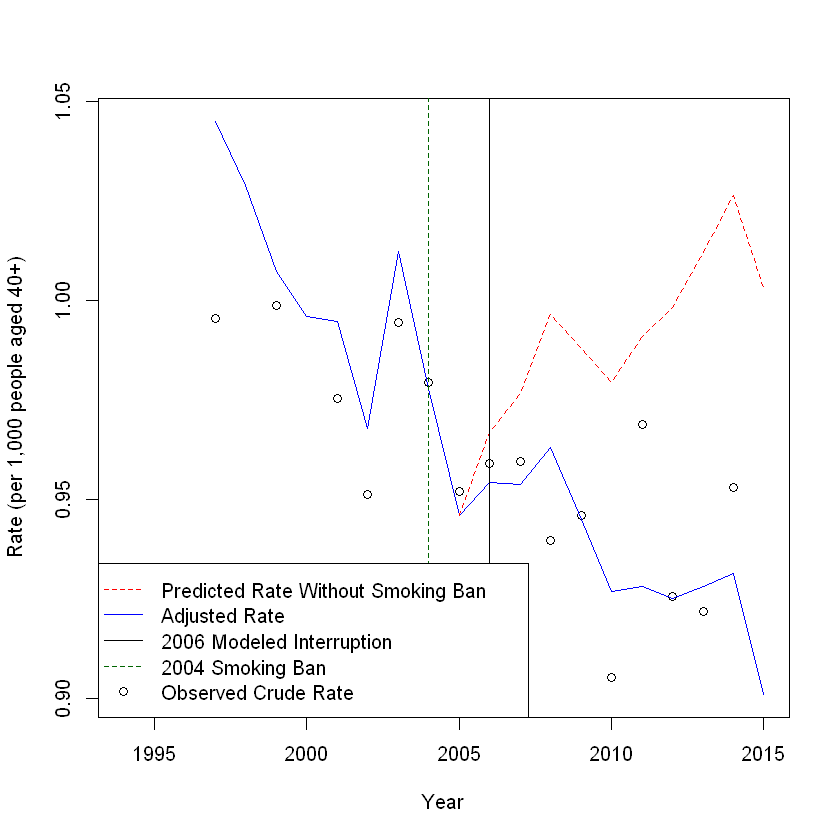

In [38]:
counterfactual <- y %>% mutate(interruption = "preban")

  y <- y %>% mutate(
    crude_rate_orig = (lungMortality)/population,
    with_smoking_ban = predict(final_model, type="response", y),
    without_smoking_ban = predict(final_model, type="response", counterfactual),
    with_smoking_ban_rate = predict(final_model, type="response", y)/population,
    without_smoking_ban_rate = predict(final_model, type="response", counterfactual)/population
  )




  ## aggregate dataset from age X sex X year observations to year observations to create a figure
  fig_dataset <- y %>% group_by(year) %>%
                transmute(
                  crude_rate = sum(lungMortality)/sum(population), #weighted.mean(original_rate, population, na.rm=T),
                  crude_rate_wtd = weighted.mean(crude_rate_orig, population, na.rm=T),
                  with_smoking_ban_rate = weighted.mean(with_smoking_ban_rate, population, na.rm=T),
                  without_smoking_ban_rate = weighted.mean(without_smoking_ban_rate, population, na.rm=T),
                  without_smoking_ban_rate_direct = sum(without_smoking_ban)/sum(population),
                  with_smoking_ban_rate_direct = sum(with_smoking_ban)/sum(population)
                ) %>% ungroup()

  fig_dataset <- fig_dataset %>%
                      select(year, crude_rate, crude_rate_wtd, with_smoking_ban_rate, without_smoking_ban_rate,
                             with_smoking_ban_rate_direct, without_smoking_ban_rate_direct) %>%
                      unique()
  post_interruption <- fig_dataset %>% filter(year >= int - 1)


  plot(fig_dataset$year, fig_dataset$crude_rate_wtd, xlab="Year", ylab="Rate (per 1,000 people aged 40+)",
   ylim=c(min(c(fig_dataset$without_smoking_ban_rate,fig_dataset$with_smoking_ban_rate,fig_dataset$with_smoking_ban_rate_direct),na.rm=T),
          max(c(fig_dataset$without_smoking_ban_rate,fig_dataset$with_smoking_ban_rate,fig_dataset$with_smoking_ban_rate_direct),na.rm=T))
  )

  lines(fig_dataset$year, fig_dataset$with_smoking_ban_rate,            type="l",col="blue")
  lines(post_interruption$year, post_interruption$without_smoking_ban_rate, type="l",lty="dashed",col="red")
  abline(v=int,col="black")
  abline(v=2004,lty="dashed",col="darkgreen")
  legend("bottomleft",legend=c("Predicted Rate Without Smoking Ban","Adjusted Rate",
                            paste0(int," Modeled Interruption"),"2004 Smoking Ban", "Observed Crude Rate"),
         col=c("red","blue","black","darkgreen","black"),lty=c(2,1,1,2, NA),pch=c(NA,NA,NA,NA, 1))



Conclusion
-------------

...and that's it! You've completed the analysis. 

**What if you wanted to compare two populations -- one that experienced the intervention and one that didn't?**

Let's say that we wanted to compare Ireland, which has a comprehensive workplace smoking ban, to Marlboro-land, a country that does not. It's very easy! Just create a new category for "country" so that now your observations are identified by year, age-group, sex, and country. When you create your interruption term, just make sure you code it as follows:

* Ireland Pre-Interruption = "Pre-Interruption"
* Ireland Post-Interruption = "Post-Interruption"
* Marlboro-Land Pre-Interruption = "Pre-Interruption"
* Marlboro-Land Post-Interruption = "Pre-Interruption"

The intuition here is that Marlboro-land never has the policy, so it's always "pre" the interruption.


Additional Information
------------
My code for this project is available on my [Github page](https://www.github.com/tlcaputi).


Acknowledgements
-------------
Special thanks to the faculty at University College Cork who helped me with this project and to the following data providers who made my analysis possible:

* National Cancer Registry Ireland (Cancer Incidence Data)
* Central Statistics Office Ireland (Population and Cancer Mortality Data)
* Ireland Environmental Protection Agency (Air Quality Data)
* Ireland Health Services Executive (Active Smoking Data)

About Me
---------

My name is Theodore Caputi. I received a Bachelor of Science degree from the Wharton School at the University of Pennsylvania in 2017 and a Master of Public Health from University College Cork in 2018. Have questions? I'm available at tcaputi \[at\] gmail.com. 